In [3]:
# 加载数据分析常用库
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

import argparse
import sys
import matplotlib as mpl
#用来正常显示中文
mpl.rcParams['font.sans-serif'] = ['KaiTi']
mpl.rcParams['font.serif'] = ['KaiTi']
# mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题,或者转换负号为字符串
import pandas as pd#导入数据的包
import numpy as np#NumPy 是一个运行速度非常快的数学库，主要用于数组计算
import tensorflow as tf
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# log_dir = 'E:\\张力' 
#加载数据
f=open('E:\实验室文件\实验室文件\张力\old.csv') 
df=pd.read_csv(f)#读入数据从csv文件中导入数据
data=df.iloc[:,0:6].values#取1到6列
print(data.shape)#返回数据3374*6
print(data)

#定义常量
rnn_unit=10       #隐藏层神经元个数
input_size=5      #输入层神经元个数
output_size=1     #输出层神经元个数
lr=0.0006         #定义初始学习率
# 在TensorFlow的世界里，变量的定义和初始化是分开的，所有关于图变量的赋值和计算都要通过tf.Session的run来进行。
# 想要将所有图变量进行集体初始化时应该使用tf.global_variables_initializer。


# 在TensorFlow的世界里，变量的定义和初始化是分开的，一开始，tf.Variable 得到的是张量，而张量并不是具体的值，而是计算过程

#初始化输入层、输出层权重、偏置
with tf.name_scope('w'):
    weights={
             'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
             'out':tf.Variable(tf.random_normal([rnn_unit,1]))#5*10,10*1 
             }
with tf.name_scope('b'):
    biases={
            'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
            'out':tf.Variable(tf.constant(0.1,shape=[1,]))#10
            }

#分割数据集，将数据分为训练集和验证集，后7天作为测试集
def get_data(batch_size=300,time_step=5,train_begin=0,train_end=3367):
        batch_index=[]    
        scaler_for_x=MinMaxScaler(feature_range=(0,1))  #用MinMaxScaler()函数将数据处理为（0，1）上的数
        scaler_for_y=MinMaxScaler(feature_range=(0,1))
        scaled_x_data=scaler_for_x.fit_transform(data[:,:-1])#将data[:,:-1]数据转化为0-1之间的数值
        scaled_y_data=scaler_for_y.fit_transform(data[:,-1].reshape(-1,1))
        scaled_y_data = scaled_y_data.flatten()#返回一个一维数组。
    #     data_train=data[train_begin:train_end]
        label_train = scaled_y_data[train_begin:train_end]
        print('label_train')
        print(len(label_train))
        label_test = scaled_y_data[train_end:]
        print('label_test')
        print(len(label_test))
        normalized_train_data = scaled_x_data[train_begin:train_end]#得到标准化的训练数据
        normalized_test_data = scaled_x_data[train_end:]#得到标准化的测试数据

        train_x,train_y=[],[]   #训练集x和y初定义
        #下面这个循环就是得到train_x,train_y=[],[]
        for i in range(len(normalized_train_data)-time_step):
            if i % batch_size==0:
                batch_index.append(i)#将能整出60的数追加在batch_index中
            x=normalized_train_data[i:i+time_step,:5]
            y=label_train[i:i+time_step,np.newaxis]
            train_x.append(x.tolist())#将数组或者矩阵变为列表#训练输入
            train_y.append(y.tolist())#训练输出
        print('train_x')
        print(len(train_x))
        print('输出train_y')
        print(len(train_y))
        batch_index.append((len(normalized_train_data)-time_step))
        print('len(normalized_test_data)')
        print(len(normalized_test_data))
        print('----------------------')
#             size=(len(normalized_test_data)+time_step-1)//time_step  #有size个sample 
        size=1
        test_x,test_y=[],[]
        print("normalized_test_data")
        print(normalized_test_data)
        print('----------------------')
        print("label_test")
        print(label_test)
        print("-----------------------------------")
        print('size')
        print(size)
        print("-----------------------------------")
        #下面这个循环是得到test_x,test_y=[],[]
        for i in range(size):
            print('i',i)
#                 x=normalized_test_data[i*time_step:(i+1)*time_step,:5]
            x=normalized_test_data[i*time_step:7,:5]
            y=label_test[i*time_step:(i+1)*time_step]
            test_x.append(x.tolist())
            test_y.extend(y)
        print('前输出test_x')
        print(type(test_x))
        print(len(test_x))
        print(test_x)
#             test_x.append((normalized_test_data[(i+1)*time_step:,:5]).tolist())#测试输入
        test_y.extend((label_test[(i+1)*time_step:]).tolist())#测试输出
        print('输出test_x')
        print(type(test_x))
        print(len(test_x))
#             test_x=np.array(test_x)
        print(test_x)
        print('----------------------')
        print('输出test_y')
        print(len(test_y))

        print(test_y)
        print('----------------------')
        print('输出train_x')
        print(len(train_x))
#             print(train_x)
        return batch_index,train_x,train_y,test_x,test_y,scaler_for_y

#——————————————————定义神经网络变量——————————————————
def lstm(X):  
    batch_size=tf.shape(X)[0]
    time_step=tf.shape(X)[1]
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入

    input_rnn=tf.matmul(input,w_in)+b_in#matmul（）函数是矩阵乘法

    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
    cell=tf.contrib.rnn.BasicLSTMCell(rnn_unit)#调用lstm
#         cell=tf.nn.rnn_cell.BasicRNNCell(rnn_unit)
    #cell=tf.contrib.rnn.core_rnn_cell.BasicLSTMCell(rnn_unit)
    init_state=cell.zero_state(batch_size,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)  #output_rnn是记录lstm每个输出节点的结果，final_states是最后一个cell的结果
    output=tf.reshape(output_rnn,[-1,rnn_unit]) #作为输出层的输入
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
#     pred=tf.nn.softmax(tf.matmul(output,w_out)+b_out)
    return pred,final_states

#——————————————————训练模型——————————————————

    #损失函数
#     loss=tf.nn.softmax_cross_entropy_with_logits(labels=tf.reshape(Y, [-1]),logits=tf.reshape(pred,[-1]))
    #loss=tf.reduce_mean(l)
    
    #with tf.name_scope('loss'):
loss_= np.zeros([1])#这里初始化loss
def train_lstm(batch_size=300,time_step=7,train_begin=0,train_end=3367):
#     with tf.name_scope('input'):
#     Tensorflow的设计理念称之为计算流图，在编写程序时，首先构筑整个系统的graph，代码并不会直接生效，
# 这一点和python的其他数值计算库（如Numpy等）不同，graph为静态的，类似于docker中的镜像。
# 然后，在实际的运行时，启动一个session，程序才会真正的运行。
# 这样做的好处就是：避免反复地切换底层程序实际运行的上下文，tensorflow帮你优化整个系统的代码。
# 我们知道，很多python程序的底层为C语言或者其他语言，执行一行脚本，就要切换一次，是有成本的，tensorflow通过计算流图的方式，
# 帮你优化整个session需要执行的代码，还是很有优势的。


# 所以placeholder()函数是在神经网络构建graph的时候在模型中的占位，此时并没有把要输入的数据传入模型，它只会分配必要的内存。
# 等建立session，在会话中，运行模型的时候通过feed_dict()函数向占位符喂入数据。
# tf.placeholder（）中的shape参数意思是形状，默认是none，既可以是多维，又可以是一维数据
        X=tf.placeholder(tf.float32, shape=[None,time_step,input_size],name='x-input')
        Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size],name='y-input')
        batch_index,train_x,train_y,test_x,test_y,scaler_for_y = get_data(batch_size,time_step,train_begin,train_end)
        #调用lstm
        pred,_=lstm(X)
        #                 损失函数
        loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])),name='loss')
#                 优化器
        train_op=tf.train.AdamOptimizer(lr).minimize(loss)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())#初始化模型变量参数
        #重复训练5000次
            iter_time = 1
            for i in range(iter_time):
                for step in range(len(batch_index)-1):
                    _,loss_[i]=sess.run([train_op,loss],feed_dict={X:train_x[batch_index[step]:batch_index[step+1]],Y:train_y[batch_index[step]:batch_index[step+1]]})
                if i % 50 == 0:
                    print('iter:',i,'loss:',loss_[i])
            ####预测模型####
            test_predict=[]
#                         将真实数据带入得到预测值
            print('len(test_x)的大小')
            print(len(test_x))
            print('test_x',test_x)
            print('pred',pred)
            for step in range(len(test_x)):
                prob=sess.run(pred,feed_dict={X:[test_x[step]]})   
                predict=prob.reshape((-1))
                print(predict)
                test_predict.extend(predict)
            test_predict=np.array(test_predict)
            print('--------------------------------------------------')
            print('test_predict未反归一化')
            print(test_predict)
            test_y=np.array(test_y)
            test_predict = scaler_for_y.inverse_transform(test_predict.reshape(1,-1))#用上面的结构反归一化
            test_y = scaler_for_y.inverse_transform(test_y.reshape(1,-1))#用上面的结构反归一化
            print('输出len(test_x)')
            print(len(test_x))
            print('test_predict值')
            print(test_predict.shape)
            print(test_predict)
            test_y=np.array(test_y)
            print('test_y值')
            print(test_y.shape)
            print(test_y)
            #判断指标
            rmse=np.sqrt(mean_squared_error(test_predict,test_y))
            mae = mean_absolute_error(y_pred=test_predict,y_true=test_y)
            test_predict = np.concatenate(test_predict, axis=0)
            error = abs(test_predict-test_y)
            ec=1-np.sqrt(sum(error*error))/(np.sqrt(sum(test_y*test_y))+np.sqrt(sum(test_predict*test_predict)));
            ec=np.mean(ec)
            print ('mae:',mae,'   rmse:',rmse,'    ec:',ec)
            test_y=test_y.reshape(-1,1)
#         test_predict=test_predict(-1,1)
            plt.figure(figsize=(12,8))
            plt.plot(test_y,  color='r')
            plt.plot(test_predict, color='b')
            plt.tick_params(labelsize=15)
            plt.legend(('预测值', '真实值', 'Masked if < -0.5'), loc='upper right',fontsize='18')  
            plt.title('LSTM交通流量预测',fontsize='22')
            plt.xlabel('时间/天',fontsize='18')
            plt.ylabel('人流量',fontsize='18')
            plt.show()

        return test_predict

test_predict = train_lstm(batch_size=300,time_step=7,train_begin=0,train_end=3367)



(3374, 6)
[[11 12 10  6  6  5]
 [12 10  6  6  5  7]
 [10  6  6  5  7  6]
 ...
 [52 48 67 53 54 67]
 [48 67 53 54 67 61]
 [67 53 54 67 61 67]]
label_train
3367
label_test
7
train_x
3360
输出train_y
3360
len(normalized_test_data)
7
----------------------
normalized_test_data
[[0.46875   0.4375    0.359375  0.4453125 0.40625  ]
 [0.4375    0.359375  0.4453125 0.40625   0.375    ]
 [0.359375  0.4453125 0.40625   0.375     0.5234375]
 [0.4453125 0.40625   0.375     0.5234375 0.4140625]
 [0.40625   0.375     0.5234375 0.4140625 0.421875 ]
 [0.375     0.5234375 0.4140625 0.421875  0.5234375]
 [0.5234375 0.4140625 0.421875  0.5234375 0.4765625]]
----------------------
label_test
[0.375     0.5234375 0.4140625 0.421875  0.5234375 0.4765625 0.5234375]
-----------------------------------
size
1
-----------------------------------
i 0
前输出test_x
<class 'list'>
1
[[[0.46875, 0.4375, 0.359375, 0.4453125, 0.40625], [0.4375, 0.359375, 0.4453125, 0.40625, 0.375], [0.359375, 0.4453125, 0.40625, 0.375, 0.52

ValueError: Variable rnn/basic_lstm_cell/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "D:\software\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()
  File "D:\software\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "D:\software\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "D:\software\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "D:\software\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)


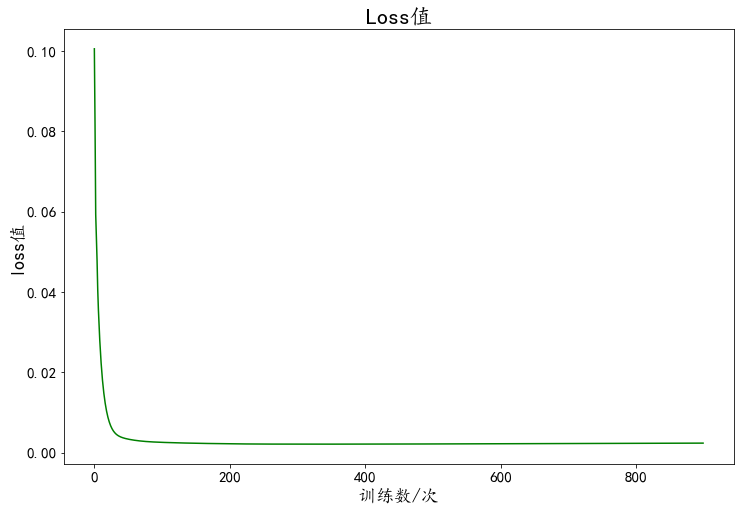

NameError: name 'final_states' is not defined

In [33]:
plt.figure(figsize=(12,8))
plt.plot(loss_,  color='green')
plt.tick_params(labelsize=15)
plt.title('Loss值',fontsize='22')
plt.xlabel('训练数/次',fontsize='18')
plt.ylabel('loss值',fontsize='18')
plt.show()


NameError: name 'final_states' is not defined